In [61]:
%matplotlib inline
%load_ext snakeviz

In [2]:
from fastai.audio import *

In [3]:
torch.cuda.set_device(1)

In [4]:
sg_cfg= SpectrogramConfig(hop=80, n_mels=80, n_fft=480, top_db=80, f_min=20.0, f_max=16000)
config_split= AudioConfig(resample_to = 8000, remove_silence="all", silence_padding=200, silence_threshold=20, sg_cfg=sg_cfg, duration=5000, pad_mode='zeros-after')

In [5]:
train_df = pd.read_csv(Path("./data/train.tsv"),sep="\t")

In [6]:
class ImageAudioList(AudioList):
    _bunch = ImageDataBunch
    context = 11
    def reconstruct(self, x): return Image(torch.stack([i[:,self.context+1] for i in x],dim=1).unsqueeze(0))
    
    def show_xys(self, xs, ys)->None:
        items = [[x,y] for i, (x,y) in enumerate(zip(xs,ys))]
        for item in items:
            display(*item)

In [7]:
# class DeepSpeechAudioList(AudioList):
#     _bunch = ImageDataBunch
#     def __init__(self, items, path, config=AudioConfig(), context=5, **kwargs):
#         super().__init__(items=items, path=path, config=config, **kwargs)
#         self.context = context
        
#     def get(self,i):
#         one_spectro = super().get(i).spectro
#         one_spectro = F.pad(one_spectro, pad=(self.context,self.context))
#         return torch.stack([one_spectro[:,:,i:i+(self.context*2+1)].squeeze() for i in range(one_spectro.shape[-1]-(self.context*2))])
    
#     def reconstruct(self, x): return Image(torch.stack([i[:,self.context+1] for i in x],dim=1).unsqueeze(0))
    
#     def show_xys(self, xs, ys)->None:
#         items = [[x,y] for i, (x,y) in enumerate(zip(xs,ys))]
#         for item in items:
#             display(*item)

In [8]:
class SentenceCharList(ItemList):
    
    itoc = list("abcdefghijklmnopqrstuvwxyz '")+['']
    ctoi = defaultdict(lambda: 28)
    def __init__(self, items, path, **kwargs):
        super().__init__(items, **kwargs)
        for i,char in enumerate(self.itoc):
            self.ctoi[char]=i
        
    def get(self,i):
        return F.pad(torch.tensor([self.ctoi[j] for j in self.items[i].lower()]), pad=(0,200), mode='constant', value=28)[:100]

    def reconstruct(self, t:Tensor):
        return "".join((self.itoc[c] for c in t[0]))

In [9]:
#My solution to having to look through training files to make sure they are in training and not validation. 
train_file = defaultdict(bool)
for i in train_df.path:
    train_file[i] = True

In [10]:
def _slice_context(b, context):
    x,y = b
    input_lengths = []
    for input_line in x.sum(dim=2).flip(2,):
        count=0
        total_length = input_line[0].shape[0]
        for elem in input_line[0]:
            if elem != 0.0000:
                break;
            count+=1
        input_lengths.append(total_length-count)
    input_lengths = torch.tensor(input_lengths)
    x = F.pad(x, pad=(context,context))
    x = torch.stack([x[:,:,:,i:i+(context*2+1)] for i in range(x.shape[-1]-(context*2))],dim=2).squeeze()
    return x,(y,input_lengths)

In [11]:
data = (ImageAudioList.from_folder("data/clips", config=config_split)
#        .use_partial_data(0.05, seed=42)
        .filter_by_func(lambda x: train_file[x.name])
        .split_by_rand_pct(0.25, seed=42)
        .label_from_func(lambda x: train_df[train_df.path==str(x).split("/")[-1]]["sentence"].iloc[0], label_cls=SentenceCharList)
        .databunch(bs=32)
        .normalize()
       )

Preprocessing: Resampling to 8000


Preprocessing: Removing Silence


Preprocessing: Resampling to 8000


Preprocessing: Removing Silence


In [12]:
data.add_tfm(partial(_slice_context, context=11))

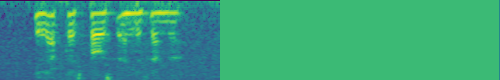

'he left his post in december'

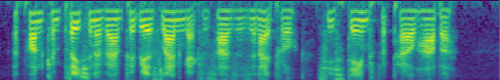

'upon completion of amphibious landing exercises in april she steamed for pearl harbor'

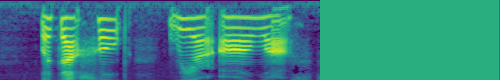

'without hope we are all lost'

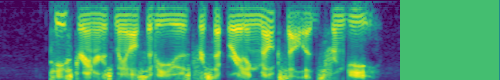

'tea strainers may also be used for separating milk solids from ghee'

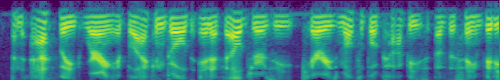

'an athlete wearing a black and gold nfl jersey carries multiple copies of the same video game'

In [13]:
data.show_batch()

In [22]:
class DeepSpeech(nn.Module):
    def __init__(self, context=5, bs=64):
        super(DeepSpeech, self).__init__()
        self.bs = bs
        self.context = context
        self.flatten = nn.Flatten()#lambda x: torch.reshape(x,(-1,1,2432))
        self.h1 = nn.Linear(80*2*self.context+80,2048)
        self.h2 = nn.Linear(2048,2048)
        self.h3 = nn.Linear(2048,2048)
        #self.h4 = nn.LSTM(2048,2048,bidirectional=True,batch_first=True)
        self.h4 = nn.RNN(2048,2048, nonlinearity="relu",bidirectional=True)
        self.h5 = nn.Linear(2048,29) #ct ∈ {a,b,c, . . . , z, space, apostrophe, blank}
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        x = x.view(x.shape[0],-1,80*2*self.context+80)
        x = self.h1(x).clamp(min=0, max=20)
        x = self.h2(x).clamp(min=0, max=20)
        x = self.h3(x).clamp(min=0, max=20)
        x,h = self.h4(x)
        x = x.view(-1,500,2,2048)
        x = x.sum(dim=2)
        x = self.h5(x).clamp(min=0, max=20)
        x = self.softmax(x)
        x = x.permute(1,0,2)
        return x

In [23]:
# def ctc_loss(input, target, bs=64, blank=28):
#     r"""Loss function that makes CTC Loss easier to use especially for putting into a fastai Learner"""
#     i_length = torch.tensor([sum([1 for i in t.sum(1) if i != 0]) for t in input])
#     input = input.permute(1,0,2).detach().requires_grad_()
#     ctc = nn.CTCLoss(blank=blank, zero_infinity=True, reduction="sum")
#     t_length = torch.tensor([sum([1 for i in t if i != blank])for t in target])
#     ret = ctc(input, target, input_lengths=i_length, target_lengths=t_length)#torch.tensor([100]*input.size(1)))
#     return ret

In [24]:
#def calculate_sizes(x):
#    return x.shape[1] - (x.argmax(dim=2) == 28).sum(dim=1) - 1
    
def calculate_sizes(x):
    return x.shape[0] - (x.argmax(dim=2)==28).sum(axis=0)
#     input_lengths = []
#     for input_line in x.argmax(dim=2).flip(1,)==x.argmax(dim=2).flip(1,)[:,0][:,None]:
#         count=0
#         total_length = input_line.shape[0]
#         for elem in input_line:
#             if not elem:
#                 break;
#             count+=1
#         input_lengths.append(total_length-count)
    
#     return torch.tensor(input_lengths)
    
def ctc_loss(log_loss, target, i_length, bs=64, blank=28):
    r"""Loss function that makes CTC Loss easier to use especially for putting into a fastai Learner"""
    #i_length = torch.tensor([sum([1 for i in t.sum(1) if i != 0]) for t in input])
    i_length = i_length.long()
    ctc = nn.CTCLoss(blank=blank, zero_infinity=True, reduction="sum")
    t_length = target.shape[-1]-(target==28).sum(dim=1).long()
    target = target.long()
    #t_length = torch.tensor([sum([1 for i in t if i != blank])for t in target])
    ret = ctc(log_loss, target, input_lengths=i_length, target_lengths=t_length)
    #ret = F.ctc_loss(log_loss, target, input_lengths=i_length, target_lengths=t_length, blank=blank, reduction="sum", zero_infinity=True)
    return ret

In [25]:
model = DeepSpeech(context=data.x.context, bs=data.batch_size)

In [26]:
apply_init(model, nn.init.kaiming_normal_)

In [27]:
learn = Learner(data, model, loss_func=partial(ctc_loss,bs=data.batch_size))

In [28]:
#learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


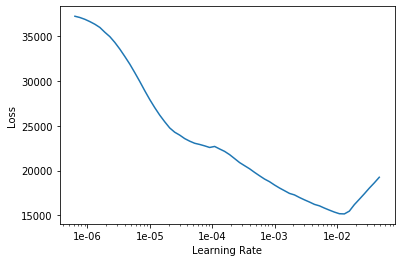

In [29]:
learn.lr_find();learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,time
0,4342.107910,4201.421387,08:22
1,3589.986328,3523.359863,08:21
2,3207.551514,3263.157471,08:22


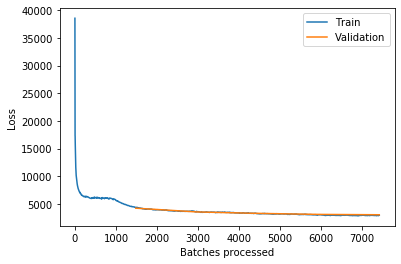

In [31]:
learn.recorder.plot_losses()

In [29]:
#learn.save("2019_10_18_01_DeepSpeechFastai", return_path=True)

PosixPath('data/clips/models/2019_10_18_01_DeepSpeechFastai.pth')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


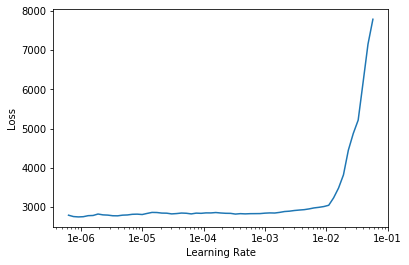

In [36]:
learn.lr_find();learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,time
0,3120.409668,3179.798340,08:16


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


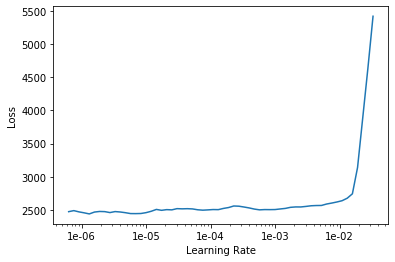

In [42]:
learn.lr_find();learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,time
0,2751.210693,3057.677734,08:16
1,2920.008789,3085.418457,08:21
2,2793.602051,3002.497314,08:19
3,2542.222656,2913.833252,08:20


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


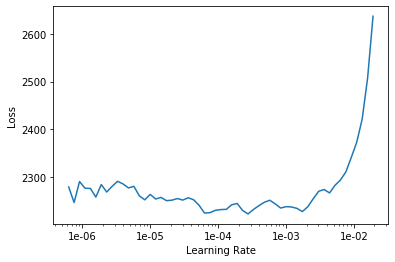

In [48]:
learn.lr_find();learn.recorder.plot()

In [49]:
learn.fit_one_cycle(5,2e-4)

epoch,train_loss,valid_loss,time
0,2334.897949,2942.733643,08:17
1,2360.960449,2953.974854,08:19
2,2308.498535,2968.619385,08:19
3,2112.832031,3004.901367,08:20
4,2088.155762,3022.803711,08:21


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


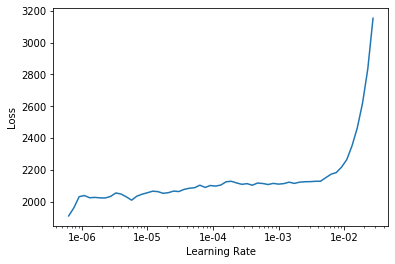

In [62]:
learn.lr_find();learn.recorder.plot()

In [63]:
%%snakeviz
learn.fit_one_cycle(5,2e-4)

epoch,train_loss,valid_loss,time
0,2158.150391,3042.019531,08:16
1,2161.210693,3058.422607,08:22
2,2076.484863,3091.651367,08:22
3,1985.902710,3139.312256,08:21
4,1930.622803,3176.771973,08:22


 
*** Profile stats marshalled to file '/tmp/tmpkevdxsv1'. 
Embedding SnakeViz in this document...


In [54]:
inp,targs = next(iter(learn.data.valid_dl))

In [55]:
preds = learn.model(inp)

In [56]:
# Thanks to Lucas (https://colab.research.google.com/drive/1qpyHOM2zonVc84FKRV0lqy-eiWYW2eyl#scrollTo=MsJ8BUhbOXo4) for this piece of code
def ctc_decoder(sequence, eps):
    #Step 1: merge equal stuff
    sequence = sequence.cpu().numpy()
    out = [sequence[0]]
    for item in sequence:
        if item != out[-1]: out.append(item)        
    #Step 2: remove all of the special token (eps)
    out = [p for p in out if p!=eps]
    return out

In [57]:
#data.valid_ds[phrase][0].show()
for phrase in range(32):
    print("".join([learn.data.itoc[i] for i in ctc_decoder(preds.argmax(dim=2)[:,phrase], 28)]))
    print("".join([learn.data.itoc[i] for i in targs[0][phrase]]))

aftethe war redinst belnin the win brae nap or d foa thesaber
after the war residents began leaving the woodbridge neighborhood for the suburbs
he was noclospacatistomen h in ameation
he was now clasping his hands together in admiration
it eten norteyster an fobinga
it is in northeastern pennsylvania
finly fie es lata daramo recold a tid capti
finally five years later jeremiah records a third captivity
h repordyd to feed omostse clouifla ontrenas and 
it is reported to feed almost exclusively on tree snails and slugs
sel to war  a you wout li e tetel
feel towards you as you would like me to feel
two silhe lets of goger athi gol undurpa dendi lit tonnol
two silhouettes of joggers as they go under a dimly lit tunnel
hee e ci rite their byes on a sus banshonbrege with no ars the abla
dozens of cyclists ride their bikes on a suspension bridge with no cars visible
the cosste is a ti coma fanily bemeran mutelitraction
the coaster is a vekoma family boomerang model attraction
she wa tesperd s